# Kinked beam

<figure>
  <IMG SRC="https://raw.githubusercontent.com/ibcmrocha/public/main/newforce.png" WIDTH=300 ALIGN="center">
</figure>

With:
- $l_1 = 4$
- $l_2 = 5$
- $l_3 = 3$
- $EI = 5000$
- $EA = 15000$
- $q = 6$
- $F = 40$

Solve this problem.

> - This problem could be solved without any additional coding by adding an additional node at the points load halfway beam (2)
> - Another options is to add an element with a concentrated load at midspan. This option is chosen here.

In [1]:
import numpy as np
import matplotlib as plt
import matrixmethod as mm
import sympy as sym
sym.init_printing()
%config InlineBackend.figure_formats = ['svg']

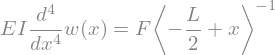

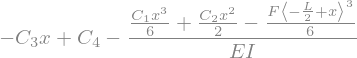

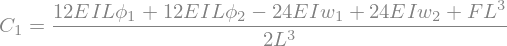

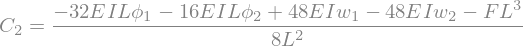

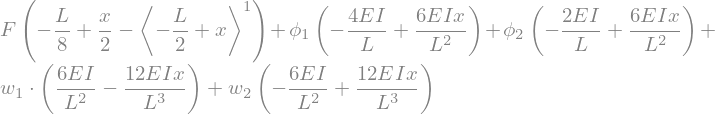

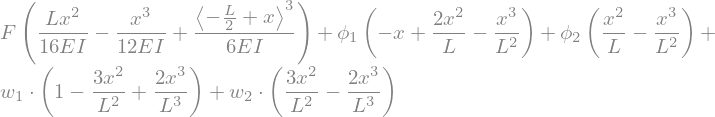

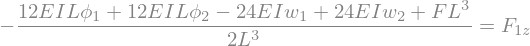

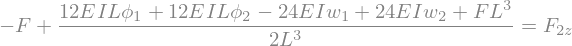

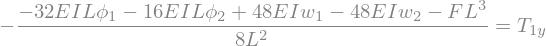

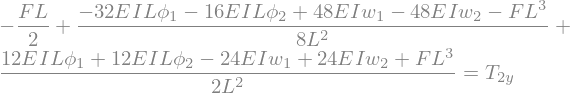

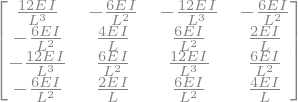

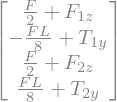

In [2]:
EI, F, x = sym.symbols('EI, F, x')
L = sym.symbols('L',positive=True)
w = sym.Function('w')

ODE_bending = sym.Eq(w(x).diff(x, 4) *EI, F*sym.SingularityFunction(x, L/2, -1))
display(ODE_bending)

V = - sym.integrate(ODE_bending.rhs, x) + sym.symbols('C1')
M = sym.integrate(V, x) + sym.symbols('C2')
kappa = M / EI
phi = sym.integrate(kappa, x) + sym.symbols('C3')
w = -sym.integrate(phi, x) + sym.symbols('C4')
display(w)

w_1, w_2, phi_1, phi_2 = sym.symbols('w_1, w_2, phi_1, phi_2')
phi = -w.diff(x)
eq1 = sym.Eq(w.subs(x,0),w_1)
eq2 = sym.Eq(w.subs(x,L),w_2)
eq3 = sym.Eq(phi.subs(x,0),phi_1)
eq4 = sym.Eq(phi.subs(x,L),phi_2)
C_sol = sym.solve([eq1, eq2, eq3, eq4 ], sym.symbols('C1, C2, C3, C4'))
for key in C_sol:
    display(sym.Eq(key, C_sol[key]))

display(sym.collect(M.subs(C_sol).expand(),[w_1,w_2,phi_1,phi_2, F]))
display(sym.collect(w.subs(C_sol).expand(),[w_1,w_2,phi_1,phi_2, F]))

F_1_z, F_2_z, T_1_y, T_2_y = sym.symbols('F_1_z, F_2_z, T_1_y, T_2_y')

eq5 = sym.Eq(-V.subs(C_sol).subs(x,0), F_1_z)
eq6 = sym.Eq(V.subs(C_sol).subs(x,L), F_2_z)
eq7 = sym.Eq(-M.subs(C_sol).subs(x,0), T_1_y)
eq8 = sym.Eq(M.subs(C_sol).subs(x,L), T_2_y)
display(eq5, eq6, eq7, eq8)

A, b = sym.linear_eq_to_matrix([eq5,eq7, eq6, eq8], [w_1, phi_1, w_2, phi_2])
display(A,b)

> - So, the load vector is: $\left[\begin{matrix}\frac{F}{2}\\- \frac{F L}{8}\\\frac{F}{2}\\\frac{F L}{8}\end{matrix}\right]$
> - The new expression for M is: $- \frac{F L}{8} + \frac{F x}{2} - F \left(\begin{cases} - \frac{L}{2} + x & \text{for}\: x > \frac{L}{2} \\0 & \text{otherwise} \end{cases}\right) + \phi_{1} \left(- \frac{4 EI}{L} + \frac{6 EI x}{L^{2}}\right) + \phi_{2} \left(- \frac{2 EI}{L} + \frac{6 EI x}{L^{2}}\right) + w_{1} \cdot \left(\frac{6 EI}{L^{2}} - \frac{12 EI x}{L^{3}}\right) + w_{2} \left(- \frac{6 EI}{L^{2}} + \frac{12 EI x}{L^{3}}\right)$
> - The new expression for w is: $\phi_{1} \left(- x + \frac{2 x^{2}}{L} - \frac{x^{3}}{L^{2}}\right) + \phi_{2} \left(\frac{x^{2}}{L} - \frac{x^{3}}{L^{2}}\right) + w_{1} \cdot \left(1 - \frac{3 x^{2}}{L^{2}} + \frac{2 x^{3}}{L^{3}}\right) + w_{2} \cdot \left(\frac{3 x^{2}}{L^{2}} - \frac{2 x^{3}}{L^{3}}\right) + \frac{F L x^{2}}{16 EI} - \frac{F x^{3}}{12 EI} + \frac{F \left(\begin{cases} \left(- \frac{L}{2} + x\right)^{3} & \text{for}\: x > \frac{L}{2} \\0 & \text{otherwise} \end{cases}\right)}{6 EI}$
> - These changes have been implemented in the `EB_point_load_element` class

In [2]:
mm.Node.clear()
mm.Element.clear()

l1 = 4
l2 = 5
l3 = 3
EI = 5000
q = 6
F = 40
EA = 15000

nodes = []

nodes.append(mm.Node(0,0))
nodes.append(mm.Node(l1,-l3))
nodes.append(mm.Node(l1+l2,-l3))

elems = []

elems.append(mm.Element(nodes[0], nodes[1]))
elems.append(mm.EB_point_load_element(nodes[1], nodes[2]))

section = {}
section['EI'] = EI
section['EA'] = EA
elems[0].set_section (section)
elems[1].set_section (section)

elems[0].add_distributed_load([0,q])
elems[1].add_point_load_halfway(F)

con = mm.Constrainer()

con.fix_node (nodes[0])
con.fix_dof (nodes[2], 0)
con.fix_dof (nodes[2], 1)

nodes[1].add_load ([0,F,0])

print(con)
for elem in elems:
    print(elem)

global_k = np.zeros ((3*len(nodes), 3*len(nodes)))
global_f = np.zeros (3*len(nodes))

for e in elems:
    elmat = e.stiffness()
    idofs = e.global_dofs()
    
    global_k[np.ix_(idofs,idofs)] += elmat

for n in nodes:
    global_f[n.dofs] += n.p

Kff, Ff = con.constrain ( global_k, global_f )
u = np.matmul ( np.linalg.inv(Kff), Ff )
print(u)

print(con.support_reactions(global_k,u,global_f))

This constrainer has constrained the degrees of freedom: [0, 1, 2, 6, 7] with corresponding constrained values: [0, 0, 0, 0, 0])
Element connecting:
node #1:
 This node has:
 - x coordinate=0,
 - z coordinate=0,
 - degrees of freedom=[0, 1, 2],
 - load vector=[  9.   12.  -12.5]
with node #2:
 This node has:
 - x coordinate=4,
 - z coordinate=-3,
 - degrees of freedom=[3, 4, 5],
 - load vector=[  9.   72.  -12.5]
Element connecting:
node #1:
 This node has:
 - x coordinate=4,
 - z coordinate=-3,
 - degrees of freedom=[3, 4, 5],
 - load vector=[  9.   72.  -12.5]
with node #2:
 This node has:
 - x coordinate=9,
 - z coordinate=-3,
 - degrees of freedom=[6, 7, 8],
 - load vector=[ 0. 20. 25.]
[ 0.01993089  0.07095663 -0.00927066  0.03217232]
[ 41.79266037 -77.42280736  76.42728512 -59.79266037 -26.57719264]


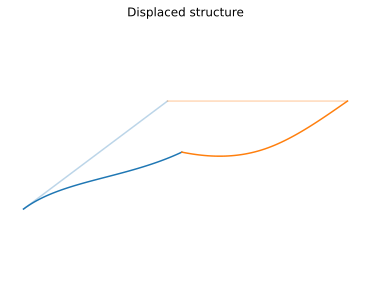

In [3]:
for elem in elems:
    u_elem = con.full_disp(u)[elem.global_dofs()]
    elem.plot_displaced(u_elem,num_points=51,global_c=True,scale=20)

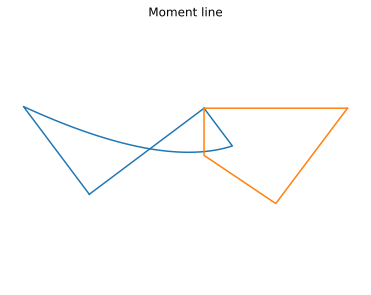

In [4]:
for elem in elems:
    u_elem = con.full_disp(u)[elem.global_dofs()]
    elem.plot_moment_diagram(u_elem,num_points=51,global_c=True,scale=0.05)